In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import plotly.express as px

In [2]:
# 유저 행동 데이터 처리
df_act = pd.read_csv('29_Lineage/activity.csv')
df_act.head(3)

,day,acc_id,char_id,server,playtime,npc_kill,solo_exp,party_exp,quest_exp,boss_monster,death,revive,exp_recovery,fishing,private_shop,game_money_change,enchant_count
0,1,75001,397380,aa,1.459994,0.000000,0.000000,0.000000,0.000000,0,0.00000,0.000000,0.0,0.0,1.119053,0.033934,0.0
1,1,75001,216231,aa,0.286785,2.244221,0.046989,0.000000,0.000000,0,0.00000,0.000000,0.0,0.0,0.000000,-0.013933,0.0
2,1,75711,308769,aa,1.049964,2.951697,0.321164,0.166247,0.003463,1,0.24537,0.246819,0.0,0.0,0.000000,-0.001983,0.0


In [4]:
# 유저 ID 별 캐릭터 수 / 총 플레이 시간 계산
df_act['char_num'] = 1
p1 = df_act.pivot_table(index='acc_id', values=['char_num','playtime'],
                        aggfunc='sum').reset_index()

In [5]:
# 총 획득 경험치
df_act['total_exp'] = df_act['solo_exp'] + df_act['party_exp'] + df_act['quest_exp']

In [13]:
# 유저 ID 별 캐릭터 당 평균 플레이 시간 / 평균 NPC 킬수 등...
p2 = df_act.pivot_table(index='acc_id',
                  values=['npc_kill','total_exp','death','revive',
                         'enchant_count'],
                  aggfunc='mean')
p2.shape

(40000, 5)

In [7]:
# 전투 데이터
df_combat = pd.read_csv('29_Lineage/combat.csv')

In [14]:
p3 = df_combat.pivot_table(index='acc_id', values='level',
                     aggfunc=['min','max']).reset_index()
p3.columns = ['acc_id', 'level_min','level_max']
p3.shape

(40000, 3)

In [28]:
df_combat.columns

Index(['day', 'acc_id', 'char_id', 'server', 'class', 'level', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent'],
      dtype='object')

In [31]:
p4 = df_combat.pivot_table(index='acc_id',
                     values=['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent'],
                     aggfunc='mean').reset_index()
p4.shape

(40000, 8)

In [32]:
# 잔존율에 대한 데이터를 불러와, 병합
df_label = pd.read_csv('29_Lineage/label.csv')
df_label.columns

Index(['acc_id', 'survival_time', 'amount_spent'], dtype='object')

In [33]:
# 앞서 처리한 유저의 행동/전투 데이터의 병합
m1 = pd.merge(df_label, p1, on='acc_id', how='inner')
m1.shape

(40000, 5)

In [34]:
m2 = pd.merge(m1, p2, on='acc_id', how='inner')
m2.shape

(40000, 10)

In [35]:
m3 = pd.merge(m2, p3, on='acc_id', how='inner')
m3.shape

(40000, 12)

In [36]:
df1 = pd.merge(m3, p4, on='acc_id', how='inner')
df1.shape

(40000, 19)

In [37]:
# 잔존율에 대한 Y값 계산
Y = df1['survival_time']/64
X = df1.drop(columns=['survival_time','acc_id'])

In [38]:
# 학습데이터 검증 데이터 분할
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,
                                                   test_size=0.3, random_state=1234)

# 신경망 하이퍼파라미터 튜닝

- 신경망 알고리즘은 강력한 확장성과 유연함 큰 장점이나, 하이퍼파라미터(노드, 레이어, 활성함수, 최적화 전략)에 대한 튜닝을 수행할 때, 고려할 사항이 많음
- 머신러닝의 하이퍼파라미터 튜닝했던 것 같이 딥러닝의 여러 하이퍼파라미터를 튜닝

In [40]:
# 케라스 튜너
# !pip install keras-tuner

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from kerastuner.tuners import RandomSearch

In [43]:
model1 = Sequential()
model1. add(Dense(16, activation='relu', input_shape=(17, )))
model1.add( Dense(32, activation='relu'))
model1.add( Dense(32, activation='relu'))
model1.add( Dense(32, activation='relu'))
model1.add( Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])
model1.fit(X_train, Y_train, epochs=5, validation_split=0.3)

Epoch 1/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.5473 - loss: 0.5378 - val_accuracy: 0.5124 - val_loss: 0.5341
Epoch 2/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.5376 - loss: 0.5150 - val_accuracy: 0.5331 - val_loss: 0.5448
Epoch 3/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.5318 - loss: 0.5144 - val_accuracy: 0.5152 - val_loss: 0.5194
Epoch 4/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.5276 - loss: 0.5079 - val_accuracy: 0.5219 - val_loss: 0.5121
Epoch 5/5
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.5322 - loss: 0.5022 - val_accuracy: 0.5208 - val_loss: 0.5100


In [66]:
# 하이퍼 파라미터 튜닝할 모델 함수를 구성
def build_model(hp):
    model = Sequential()
    # Input Layer 구성
    # Node수(16개 노드로 시작해 128개 노드까지 16개씩 증가) / 
    # 활성함수를 선택 (relu / tanh/ sigmoid)
    model.add(Dense(units=hp.Int('units_input',
                                min_value=16,
                                max_value=128,
                                step=16),
                   activation=hp.Choice('activation_input',
                                       values=['relu','tanh','sigmoid']),
                   input_shape=(17, )))
    
    # 중간 은닉층
    for i in range(hp.Int('num_layer', min_value=5, max_value=10)):
        model.add(Dense(units=hp.Int(f'units_{i}',
                                    min_value=16, max_value=128,
                                    step=16),
                       activation=hp.Choice(f'activation_{i}',
                                           values=['relu','tanh','sigmoid'])))
    # 최종 출력층
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

- hp.Int() : I가 대문자 / 케라스의 하이퍼파라미터 튜너
    - 특정 수의 범위를 지정하여 하이퍼파라미터를 세팅

In [67]:
# 튜너 실행
# 체크 포인트 파일 경로 설정 (하이퍼파라미터의 정보를 중간에 저장할 공간지정)
# 한글 경로가 있으면, 작동이 안될 수 있음
callback_path = '/Users/sinhyelim/'

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                    max_trials=5, # 총 튜닝 횟수
                    directory = callback_path,
                    project_name = 'keras_DL_hyperlist',
                    overwrite = False)
tuner.search(X_train, Y_train, epochs=10, validation_split=0.3)

Reloading Tuner from /Users/sinhyelim/keras_DL_hyperlist/tuner0.json


In [68]:
# 튜닝된 모델 중에서 최상의 성능을 보이는 하이퍼파라미터 세트를 확인
best_model = tuner.get_best_hyperparameters()[0]

In [70]:
# 최상의 모델의 신경망 구조를 확인
print('입력 Layer의 Node 수 :' ,best_model.get('units_input'))
print('입력 Layer의 활성함수 :' ,best_model.get('activation_input'))
print('Hidden Layer의 수 :' ,best_model.get('num_layer'))

for i in range(best_model.get('num_layer')):
    print(f'{i}번째 Layer의 Node : ', best_model.get(f'units_{i}'))
    print(f'{i}번째 Layer의 활성함수 : ', best_model.get(f'activation_{i}'))

입력 Layer의 Node 수 : 16
입력 Layer의 활성함수 : sigmoid
Hidden Layer의 수 : 7
0번째 Layer의 Node :  64
0번째 Layer의 활성함수 :  tanh
1번째 Layer의 Node :  112
1번째 Layer의 활성함수 :  relu
2번째 Layer의 Node :  48
2번째 Layer의 활성함수 :  tanh
3번째 Layer의 Node :  80
3번째 Layer의 활성함수 :  sigmoid
4번째 Layer의 Node :  128
4번째 Layer의 활성함수 :  relu
5번째 Layer의 Node :  16
5번째 Layer의 활성함수 :  relu
6번째 Layer의 Node :  16
6번째 Layer의 활성함수 :  relu


In [71]:
# 최적의 하이퍼파라미터를 도출한 모델을 구성
best_model_NN = tuner.hypermodel.build(best_model)
best_model_NN

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



<Sequential name=sequential_1, built=True>

- **Early Stopping** : 여러 Epoch 과정에서 검증 데이터 Validation Set에 대한 성능이 더이상 개선되지 않을 때, 조기에 학습을 종료

In [72]:
from keras import callbacks

In [73]:
early_stop = callbacks.EarlyStopping(patience=5,
                                     restore_best_weights=True)
# patience = 5 :5회이상 Validation Set의 성능이 개선되지 않는다면, 학습을 종료
# restore_best_weight : 조기 종료가 발생한 뒤에 최고성능을 보였던 Weight 값을
#                       모델에 유지

In [74]:
# 모델 훈련 실시
best_model_NN.fit(X_train, Y_train, epochs=50, validation_split=0.3,
                 callbacks=early_stop)

Epoch 1/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5333 - loss: 0.6332 - val_accuracy: 0.5401 - val_loss: 0.6053
Epoch 2/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.5510 - loss: 0.5979 - val_accuracy: 0.5401 - val_loss: 0.6051
Epoch 3/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.5545 - loss: 0.5961 - val_accuracy: 0.5401 - val_loss: 0.6053
Epoch 4/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.5498 - loss: 0.6007 - val_accuracy: 0.5401 - val_loss: 0.6065
Epoch 5/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.5553 - loss: 0.5958 - val_accuracy: 0.5401 - val_loss: 0.6054
Epoch 6/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.5535 - loss: 0.5975 - val_accuracy: 0.5401 - val_loss: 0.6050
Epoch 7/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - accuracy: 0.5513 - loss: 0.5976 - val_accuracy: 0.5401 - val_loss: 0.6050
Epoch 8/50
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - accuracy: 0.5590 - loss: 0.5920 - va

In [75]:
def threshold_func(result):
    if result > 0.5:
        return 1
    return 0

In [77]:
Y_train_pred = pd.Series(best_model_NN.predict(X_train).flatten()).apply(threshold_func)
Y_test_pred = pd.Series(best_model_NN.predict(X_test).flatten()).apply(threshold_func)

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


In [78]:
from sklearn.metrics import classification_report

In [79]:
print(classification_report(Y_train.apply(threshold_func), Y_train_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9213
           1       0.67      1.00      0.80     18787

    accuracy                           0.67     28000
   macro avg       0.34      0.50      0.40     28000
weighted avg       0.45      0.67      0.54     28000



/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [80]:
print(classification_report(Y_test.apply(threshold_func), Y_test_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3908
           1       0.67      1.00      0.81      8092

    accuracy                           0.67     12000
   macro avg       0.34      0.50      0.40     12000
weighted avg       0.45      0.67      0.54     12000



/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/sinhyelim/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
best_model_NN.save()

# RNN Model

- RNN(Recurrent Neural Network) : 순차적인(Sequence Data) 데이터를 효과적으로 처리하기 위한 딥러닝 모델 (문자열/ 시계열/ 서열)
- 이전의 정보를 현재의 상태에 반영하여 시간에 따라 변하는 입력값에 가중치를 주어 처리

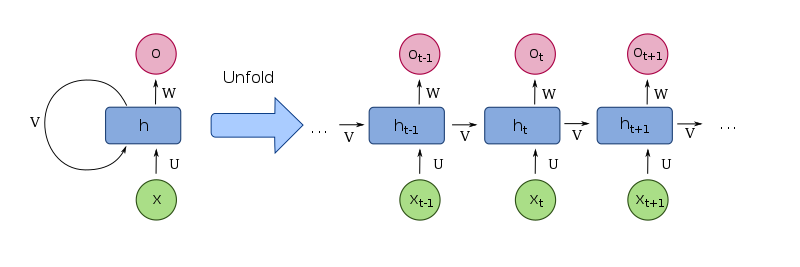

**기업 평가 데이터를 이용한 감성분석** (텍스트 마이닝)

In [129]:
df2 = pd.read_csv('24_Data.csv')
df2.head(2)

,Unnamed: 0,직무,재직상태,근무지,작성년도,작성월,기업한줄평,기업장점,기업단점,경영진희망사항,기업추천여부,추천수
0,0,기획/경영,전직원,서울,2024,3,"""부서 by 부서, 팀장 by 팀장으로 근무환경이 달라지는 곳""","사람 by 사람이 심하겠지만, 배울 점이 많은 분들 밑에서 일했습니다. 휴게실, 점...","사람 by 사람이 심한만큼, 배울 점이 많은 분들만 있는 것은 아니었습니다. 업무량...",일하는만큼 상응하는 연봉을 받고 싶습니다.,추천,0
1,1,특수계층/공공,전직원,서울,2024,2,"""과거에 비해 안좋아졌지만 그래도 괜찮은 회사""",인력 구성이 훌륭하고 사회에 이바지할 수 있다.,공공기관 특성상 상방의 한계가 뚜렷하고 급여나 복지나 부족하다.,우수 인력의 이탈을 막기 위해서는 특단의 조치가 필요,추천,0


In [130]:
df3 = df2[['기업장점','기업단점']].melt()
df3.isnull().sum()

variable    0
value       1
dtype: int64

In [131]:
df3['Target'] = df3['variable'].replace({'기업장점':1, '기업단점':0})
df3['Target'].value_counts()

Target
1    80
0    80
Name: count, dtype: int64

In [132]:
X = df3[['value']]
Y = df3['Target']

In [133]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,
                                                   random_state=1234)

In [103]:
#X_train = X_train.dropna(subset=['value'])

In [134]:
# 문자를 숫자로 (Label Encoding) 변환한 다음 -> 행렬형태로 변환 (Padding)
from konlpy.tag import Okt
import re

In [135]:
okt = Okt()

In [ ]:
# 뷸용어 처리 및 특수문자 제거
clean_word_train = [] # 텍스트가 처리된 결과를 리스트에 지정
for i in X_train['value']:
    # 특수문자 처리 (정규 표현식)
    review_txt = re.sub(r"\W+", " ", i) 
    # 문자를 제외한 한 글자 이상의 문자열을 제거(공백 값으로 바꿈)
    
    word_txt = okt.morphs(review_txt, stem=True)
    # 앞서 특수문자가 처리된 문장을 형태소 단위로 분할
    
    word_txt2 = [x for x in word_txt if not x in set(['을','를','수','것'])]
    # 불용어 처리
    
    clean_word_train.append(word_txt2)

In [105]:
# 뷸용어 처리 및 특수문자 제거
clean_word_test = [] # 텍스트가 처리된 결과를 리스트에 지정
for i in X_test['value']:
    # 특수문자 처리 (정규 표현식)
    review_txt = re.sub(r"\W+", " ", i) 
    # 문자를 제외한 한 글자 이상의 문자열을 제거(공백 값으로 바꿈)
    
    word_txt = okt.morphs(review_txt, stem=True)
    # 앞서 특수문자가 처리된 문장을 형태소 단위로 분할
    
    word_txt2 = [x for x in word_txt if not x in set(['을','를','수','것'])]
    # 불용어 처리
    
    clean_word_test.append(word_txt2)

In [106]:
# 라벨링과 패딩(Padding)에 필요한 라이브러리를 호출
from tensorflow.keras.preprocessing.text   import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [107]:
# 문자를 하나의 정수로 Labeling(Label Encoding)
token_model = Tokenizer()
token_model.fit_on_texts(clean_word_train)
train_seq = token_model.texts_to_sequences(clean_word_train)
test_seq = token_model.texts_to_sequences(clean_word_test)

In [111]:
# 숫자로 바뀐 텍스트의 리스트를 Padding 기법을 이용해 Matrix로 변환
x_train_vec = pad_sequences(train_seq, maxlen=80, padding='post')
# maxlen 숫자로 바뀐 문장의 최대 길이 (최대 단어(형태소) 수)
x_train_vec.shape

(111, 80)

In [112]:
x_test_vec = pad_sequences(test_seq, maxlen=80, padding='post')

In [114]:
from keras.layers import SimpleRNN
from keras.layers import Embedding

In [118]:
model_RNN = Sequential()
model_RNN.add(Embedding(10000,8))
model_RNN.add(SimpleRNN(32))
model_RNN.add(Dense(1, activation='sigmoid'))

model_RNN.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy'])
model_RNN.fit(x_train_vec, Y_train, epochs=10, validation_split=0.3)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5410 - loss: 0.6978 - val_accuracy: 0.5588 - val_loss: 0.6699
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6697 - loss: 0.6701 - val_accuracy: 0.4706 - val_loss: 0.6815
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7815 - loss: 0.6182 - val_accuracy: 0.4412 - val_loss: 0.7707
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8583 - loss: 0.5615 - val_accuracy: 0.5294 - val_loss: 0.7423
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8700 - loss: 0.4900 - val_accuracy: 0.5294 - val_loss: 0.7400
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9194 - loss: 0.4335 - val_accuracy: 0.4706 - val_loss: 0.8066
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9428 - loss: 0.3724 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9818 - loss: 0.3326 - val_accuracy: 0.5294 - val_loss: 0.7853


In [119]:
Y_train_pred = pd.Series(model_RNN.predict(x_train_vec).flatten()).apply(threshold_func)
Y_test_pred = pd.Series(model_RNN.predict(x_test_vec).flatten()).apply(threshold_func)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [ ]:
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

# 개별미션

- 아래의 미션을 Jupyter Notebook으로 풀이 후, [File] - [Download as]에 [HTML (.html] 로 저장하여 메일로 송부해주세요.
- 제출 양식 : [하나은행_데이터] 홍길동_개별 미션 (9주차 3일)

29_Lineage 데이터를 활용해 아래와 같은 분석을 실시하시오.

In [141]:
# 유저 행동 데이터
df_act = pd.read_csv('29_Lineage/activity.csv')
df_act.columns

Index(['day', 'acc_id', 'char_id', 'server', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'boss_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change',
       'enchant_count'],
      dtype='object')

In [144]:
# 유저 id 별 캐릭터 수 / 총 플레이 시간 계산
df_act['char_num'] = 1
p1 =df_act.pivot_table(index='acc_id', values=['char_num', 'playtime'],
                        aggfunc='sum').reset_index()

In [145]:
# 총 획득 경험치 (혼자 + 팀 + 퀘스트)
df_act['total_exp'] = df_act['solo_exp'] + df_act['party_exp'] + df_act['quest_exp']

In [147]:
# 유저 ID 별 캐릭터 당 평균 플레이 시간 / 평균 NPC 킬수 등...
p2 = df_act.pivot_table(index='acc_id',
                  values=['npc_kill', 'total_exp','death','revive',
                         'enchant_count'],
                  aggfunc='mean')

---

In [149]:
# 전투 데이터 불러오기
df_combat = pd.read_csv('29_Lineage/combat.csv')
df_combat.head(2)

,day,acc_id,char_id,server,class,level,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent
0,1,13809,54861,ap,2,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,13809,256332,ap,2,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [151]:
p3 = df_combat.pivot_table(index='acc_id', values='level',
                            aggfunc=['min', 'max']).reset_index()
p3.columns = ['acc_id', 'level_min', 'level_max']
p3.shape

(40000, 3)

In [152]:
df_combat.columns

Index(['day', 'acc_id', 'char_id', 'server', 'class', 'level', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent'],
      dtype='object')

In [153]:
p4 = df_combat.pivot_table(index='acc_id',
                     values=['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent'],
                     aggfunc='mean').reset_index()

In [154]:
# 잔존율에 대한 데이터를 불러와, 병합
df_label = pd.read_csv('29_Lineage/label.csv')
df_label.columns

Index(['acc_id', 'survival_time', 'amount_spent'], dtype='object')

In [157]:
# 앞서 처리한 유저의 행동/전투 데이터의 병합
m1 = pd.merge(df_label, p1, on='acc_id', how='inner')

In [158]:
m2 = pd.merge(m1, p2, on='acc_id', how='inner') # 평균 플레이시간 등등

In [159]:
m3 = pd.merge(m2, p3, on='acc_id', how='inner') # 캐릭터 최소 레벨/최대레벨

In [160]:
df1 = pd.merge(m3, p4, on='acc_id', how='inner')

In [161]:
df1.columns

Index(['acc_id', 'survival_time', 'amount_spent', 'char_num', 'playtime',
       'death', 'enchant_count', 'npc_kill', 'revive', 'total_exp',
       'level_min', 'level_max', 'etc_cnt', 'num_opponent', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'same_pledge_cnt',
       'temp_cnt'],
      dtype='object')

----

1. 유저 중, 소유한 캐릭터가 3개 이상인 유저들의 평균 잔존일을 계산하고, 전체 중 64일 이상 잔존한 유저의 비율을 계산하시오.

In [166]:
# 소유한 캐릭터 3개 이상
cond1 = (df1['char_num'] > 3)
df1_1 = df1.loc[cond1]

In [169]:
# 평균 잔존일
df1_1['survival_time'].mean()

46.93762767965659

In [172]:
# 전체 중 64일 이상 잔존한 유저의 비율 계산
cond2 = (df1['survival_time'] >= 64)
more64 = len(df1.loc[cond2])
total = len(df1)

print((more64/total) * 100,"%")

54.99000000000001 %


---

2. 캐릭터의 획득 총 경험치 중, 파티사냥 경험치가 20% 이상인 캐릭터들이 가장 많이 구매한 아이템이 무엇인지 확인 하시오.

-> 캐릭터의 획득 total_exp 중, party_exp 가 20% 이상인 캐릭터들이 가장 많이 구매한 item_type ? 

In [181]:
trade_df = pd.read_csv('29_Lineage/trade.csv')
trade_df.columns

Index(['day', 'time', 'type', 'server', 'source_acc_id', 'source_char_id',
       'target_acc_id', 'target_char_id', 'item_type', 'item_amount',
       'item_price'],
      dtype='object')

In [184]:
# 파티샤낭 경험치가 전체 경험치 획득의 20% 이상인 캐릭터 필터링
df_act['total_exp'] = df_act['solo_exp'] + df_act['party_exp'] + df_act['quest_exp']
party20per = df_act['party_exp'] >= 0.2 * df_act['total_exp']
char_id_party20 = df_act[party20per]['char_id']

In [188]:
char_id_20 = trade_df[trade_df['target_char_id'].isin(char_id_party20)]
item_20 = char_id_20['item_type'].value_counts().idxmax()

In [189]:
item_20

'etc'

---

3. 캐릭터의 획득 총 경험치 중, 솔로 사냥 경험치가 20% 이상인 캐릭터들이 전투 상대를 한 캐릭터 수의 분포를 히스토 그램으로 확인하시오.

In [192]:
solo20per = df_act['solo_exp'] >= 0.2 * df_act['total_exp']
char_id_solo20 = df_act[solo20per]['char_id']

In [194]:
p3 = df_combat[df_combat['char_id'].isin(char_id_solo20)]['num_opponent']

(array([1.507816e+06, 1.167000e+04, 2.247000e+03, 6.120000e+02,
        1.860000e+02, 6.700000e+01, 1.800000e+01, 5.000000e+00,
        3.000000e+00, 4.000000e+00]),
 array([ 0.        ,  5.45595875, 10.9119175 , 16.36787626, 21.82383501,
        27.27979376, 32.73575251, 38.19171126, 43.64767001, 49.10362877,
        54.55958752]),
 <BarContainer object of 10 artists>)

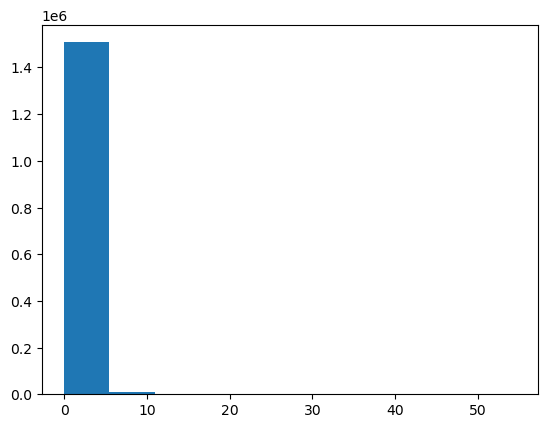

In [196]:
import matplotlib.pyplot as plt

plt.hist(p3)

---

4. '군주'직업을 가진 캐릭터들의 사망한 횟수와 '마법사'직업을 가진 캐릭터들의 사망한 횟수의 대표값의 차이가 있는지 검정하시오.

In [ ]:
# '군주' - class : 0 / '마법사' - class: 3

In [203]:
# df_combat 군주 직업 캐릭터 아이디 가져오기
char_ids_class0 = df_combat[df_combat['class'] == 0]['char_id']

# df_combat 마법사 직업 캐릭터 아이디 가져오기
char_ids_class3 = df_combat[df_combat['class'] == 3]['char_id']

In [207]:
df4_1 = df_act[df_act['char_id'].isin(char_ids_class0)]
df4_2 = df_act[df_act['char_id'].isin(char_ids_class3)]

In [208]:
df4_1.columns

Index(['day', 'acc_id', 'char_id', 'server', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'boss_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change',
       'enchant_count', 'char_num', 'total_exp'],
      dtype='object')

In [210]:
# 정규분포
# 귀무가설 : 해당 데이터의 분포는 정규분포를 따른다
# 대립가설 : 해당 데이터의 분포는 정규분포를 따르지 않는다.
print(stats.normaltest(df4_1['death']))
print(stats.normaltest(df4_2['death']))
# P.value < 0.05 / 대립가설 참
# 해당 데이터의 분포는 정규분포를 따르지 않는다

NormaltestResult(statistic=552981.191272287, pvalue=0.0)
NormaltestResult(statistic=781727.0042963286, pvalue=0.0)


In [211]:
# 정규성을 따르지 안흔 두 집단의 연속형 자료 비교
# 귀무가설 : 두 집단 간 사망횟수의 대표값의 차이가 없다
# 대립가설 : 두 집단 간 사망횟수의 대표값의 차이가 있다
stats.ranksums(df4_1['death'], df4_2['death'])
# P.value < 0.05 / 대립가설 참
# 두 집단 간 사망횟수의 대표값의 차이가 있다

RanksumsResult(statistic=-66.11940106888702, pvalue=0.0)

---

5. 레벨이 가장 높은 상위 10% 캐릭터들의 캐릭터 직업 빈도수를 확인하시오.

In [222]:
level10per = df_combat['level'].quantile(0.9)

In [224]:
level10per_cha = df_combat[df_combat['level'] >= level10per]
level10per_cha['class'].value_counts()

class
1    70600
2    47602
3    40131
4    39597
7    23503
5    13790
6     7382
0     4555
Name: count, dtype: int64

---

6. 레벨이 가장 높은 상위 10% 캐릭터들이 가장 많이 있는 서버는 어디인지 확인하시오.

In [226]:
level10per_cha['server'].value_counts().head(1)

server
bj    11595
Name: count, dtype: int64

---

7. 거래가 가장 활발하게 벌어지는 시간을 확인하고, 해당 시간에 유저들이 가장 많이 거래하는 아이템 종류를 확인하시오.

In [229]:
trade_df['time']

0          21:40:09
1          13:08:52
2          21:01:48
3          14:37:50
4          20:32:00
             ...   
2245191    23:59:54
2245192    23:59:55
2245193    23:59:57
2245194    23:59:57
2245195    23:59:57
Name: time, Length: 2245196, dtype: object

In [234]:
trade_df['time_df'] = pd.to_datetime(trade_df['time'])

/var/folders/q9/51yx3nc91mq6crjc81y6g1wm0000gn/T/ipykernel_4172/3357084126.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [236]:
trade_df['hour'] = trade_df['time_df'].dt.hour

In [243]:
trade_df['hour'].value_counts().head(1)

hour
22    178212
Name: count, dtype: int64

In [245]:
trade_df[trade_df['hour'] == 22]['item_type'].value_counts().head(1)

item_type
etc    78085
Name: count, dtype: int64

---

8. 유저의 일일 플레이시간과 가장 연관이 높은 항목을 찾고자 한다. 유저 별 총 일일 플레이시간을 계산하고, 해당 데이터와 가장 연관성 높은 항목 5가지를 상관분석/ 회귀분석을 통해 각각 도출하시오.

In [259]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [251]:
# 상관분석
correlation_matrix = df1.corr() # 상관 행렬 계산

In [255]:
playtime_corr = correlation_matrix['playtime'].sort_values(ascending=False)
playtime_corr

playtime               1.000000
survival_time          0.271866
npc_kill               0.254132
random_defender_cnt    0.204245
char_num               0.168184
etc_cnt                0.079045
pledge_cnt             0.050374
num_opponent           0.040859
temp_cnt               0.027478
death                  0.008307
revive                -0.001821
acc_id                -0.002818
level_min             -0.009309
enchant_count         -0.011811
random_attacker_cnt   -0.026737
same_pledge_cnt       -0.046771
amount_spent          -0.073406
total_exp             -0.180957
level_max             -0.301071
Name: playtime, dtype: float64

In [258]:
top5 = playtime_corr[1:6]
top5

survival_time          0.271866
npc_kill               0.254132
random_defender_cnt    0.204245
char_num               0.168184
etc_cnt                0.079045
Name: playtime, dtype: float64

In [266]:
####회귀분석
correlations = {}
for column in df1.columns:
    if column != 'playtime':
        X = df1[[column]]
        y = df1['playtime']
        model = LinearRegression()
        model.fit(X, y)
        correlations[column] = model.coef_[0]

In [269]:
correlations

{'acc_id': -2.465806705627002e-06,
 'survival_time': 0.38368574625198587,
 'amount_spent': -3.3371175400041273,
 'char_num': 0.19954445669481563,
 'death': 0.35339348428690104,
 'enchant_count': -0.9308132449868,
 'npc_kill': 13.087262498096333,
 'revive': -0.07715288534544398,
 'total_exp': -3.654871118246855,
 'level_min': -0.05314536378722331,
 'level_max': -1.9638841168327879,
 'etc_cnt': 3.8338170765276174,
 'num_opponent': 2.3490708282127297,
 'pledge_cnt': 3.333547282804704,
 'random_attacker_cnt': -2.9707676750422145,
 'random_defender_cnt': 17.080348568359028,
 'same_pledge_cnt': -6.018200025623403,
 'temp_cnt': 1.4725689310543624}

---

9. 군집 분석을 활용하여, 유저들을 총 4개의 군집으로 도출해, 해당 군집별로 유저들의 주요활동 및 전투활동에 대한 특징을 찾아 기술하시오.
    - 예시)
        - 1번 군집은 혈맹 전투를 주로 즐겨하는 유저들이고, 많이 죽으며, 아이템 거래량이 낮다 -> 주로 공성전을 많이 하는 유저들이다.
        - 2번군집은 개인 사냥을 통해 얻는 경험치가 많은 그룹이고, 죽은 횟수와 소생 횟수가 낮다 -> 주로 스토리/ 개인 사냥을 많이 하는 유저들이다.

In [279]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

In [277]:
col_list = df1.columns[1:]

In [305]:
col_list

Index(['survival_time', 'amount_spent', 'char_num', 'playtime', 'death',
       'enchant_count', 'npc_kill', 'revive', 'total_exp', 'level_min',
       'level_max', 'etc_cnt', 'num_opponent', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'same_pledge_cnt',
       'temp_cnt'],
      dtype='object')

In [283]:
cluster = KMeans(n_clusters=4, max_iter=100)
df1['C4'] = cluster.fit_predict(df1[col_list]).astype(str)
df1['C4']

0        0
1        2
2        0
3        2
4        1
        ..
39995    0
39996    0
39997    0
39998    1
39999    0
Name: C4, Length: 40000, dtype: object

In [297]:
cluster_0 = df1[df1['C4'] == '0']
cluster_1 = df1[df1['C4'] == '1']
cluster_2 = df1[df1['C4'] == '2']
cluster_3 = df1[df1['C4'] == '3']

In [313]:
print(cluster_0['amount_spent'].mean())
print(cluster_1['amount_spent'].mean())
print(cluster_2['amount_spent'].mean())
print(cluster_3['amount_spent'].mean())

0.0956037289415429
0.25242059998140465
0.07150366713032645
0.07602766104944099


In [314]:
print(cluster_0['num_opponent'].mean())
print(cluster_1['num_opponent'].mean())
print(cluster_2['num_opponent'].mean())
print(cluster_3['num_opponent'].mean())

0.27052940850111246
0.1680550676531287
0.2545314495155393
0.19246206868923849


- 클러스터 0 : 잔존기간이 높음/전투 상대 캐릭터 수가 많음/
- 클러스터 1 : 잔존기간이 낮음/일일평균결제금액이 높음/
- 클러스터 2 : 잔존기간이 높음/
- 클러스터 3 : 잔존기간이 낮음/

---

---

24_Data.csv 를 활용해 아래의 미션을 수행

1. 앞서 가져온 기업 평가 데이터에 대해 "기업한줄평"을 입력했을 때, 해당 기업을 추천하는지, 비추천하는지 판별하는 모델을 Sckikt Learn의 머신러닝알고리즘을 이용해 구성하시오.
    - Text데이터는 Text to Sequence 와 Padding 기법으로 처리
    - 특성공학 기법을 반드시 사용
    - 학습 / 일반화 성능 평가 실시

In [325]:
df5 = pd.read_csv('24_Data.csv')

In [315]:
df5

,Unnamed: 0,직무,재직상태,근무지,작성년도,작성월,기업한줄평,기업장점,기업단점,경영진희망사항,기업추천여부,추천수
0,0,기획/경영,전직원,서울,2024,3,"""부서 by 부서, 팀장 by 팀장으로 근무환경이 달라지는 곳""","사람 by 사람이 심하겠지만, 배울 점이 많은 분들 밑에서 일했습니다. 휴게실, 점...","사람 by 사람이 심한만큼, 배울 점이 많은 분들만 있는 것은 아니었습니다. 업무량...",일하는만큼 상응하는 연봉을 받고 싶습니다.,추천,0
1,1,특수계층/공공,전직원,서울,2024,2,"""과거에 비해 안좋아졌지만 그래도 괜찮은 회사""",인력 구성이 훌륭하고 사회에 이바지할 수 있다.,공공기관 특성상 상방의 한계가 뚜렷하고 급여나 복지나 부족하다.,우수 인력의 이탈을 막기 위해서는 특단의 조치가 필요,추천,0
2,2,특수계층/공공,현직원,서울,2024,1,"""여러 장단점이 있긴 한데 장점이 더 많아보입니다.""","우수한 인력, 공공에 기여한다는 자부심, 업무에 대한 경험","이에 따라가지 못하는 복지, 앞으로 더 안좋아질것으로 보이는 몇몇 요소들",좋은 회사가 될 수 있도록 노력해주세요,비추천,0
3,3,특수계층/공공,전직원,서울,2024,1,"""대외 인지도에 비해 실제로 느끼는 업무 만족도가 많이 떨어짐""","대외 인지도, 서울 여의도 고정근무(파견 2년 제외), 감독당국으로서의 권한","금융권에 비해 현저히 낮은 보수, 전문성 개발의 어려움, 금융위와의 관계로 인한 권...",열심히 일 하고 좋은 성과를 낸 직원에게 충분한 보상이 이뤄지는 인센티브 체계 구축 필요,추천,0
4,4,금융/재무,현직원,서울,2023,11,"""우수한 동료들이 많고 성장할 수 있는 곳""","- 금융시장 전반을 경험할 수 있고, 우수한 동료들과 일하며 성장할 수 있음- 전반...",- 금융감독 업무 자체가 시장에 미치는 영향이 커 업무 수행에 일부 부담 존재,직원들 처우 개선 및 더 자부심을 갖고 일할 수 있는 환경 조성,추천,0
...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,특수계층/공공,현직원,서울,2016,1,"""조직문화가 너무 보수적이고 업무강도 높음""",급여나 복지는 동종업계 최고 수준은 아니지만 좋은 편이고 공공을 위해 일한다는 자부...,조직 문화가 수직적이고 보수적이며 승진이 굉장히 늦고 업무 강도가 너무 높다,직원들의 불만에 귀기울어줬으면 좋겠고 딱딱한 회사 문화를 바꿔주면 좋겠다,비추천,0
76,76,교육,전직원,서울,2015,1,"""안정적이지만 화려한 미래를 꿈꾸기엔 부족""","대기업 수준의 급여수준, 보람과 자부심, 정년보장","퇴사후 금융사 취업 금지로 이직이 제한적,",NaN,추천,10
77,77,전문직,현직원,서울,2015,1,"""경쟁이 치열하고 개인적인 분위기. 업무에 따라 만족도 천차만별. 2-3년 주기의 ...",급여 높은 편이고 업무에 대한 자부심,분위기 경쟁적. 치열. 성과평가 제대로안됨,업무 기여 평가가 제대로 되어 그에 따른 보상이 적절해야함,추천,4
78,78,서비스/고객지원,전직원,광주,2014,10,"""현장실습생으로 근무를 해보았는데 정말 좋은 공기업이라고 생각됩니다""","업무시간, 부서 분위기, 복지, 실적에 대한 부담이 없음",민원상담을 할 때 약간의 어려움이 있을 수도 있습니다. 민원팀에서 근무시,금소원의 분리가 필요하지 않은가 생각됩니다,추천,1


In [316]:
df5.columns

Index(['Unnamed: 0', '직무', '재직상태', '근무지', '작성년도', '작성월', '기업한줄평', '기업장점',
       '기업단점', '경영진희망사항', '기업추천여부', '추천수'],
      dtype='object')

In [326]:
df6 =df5[['기업한줄평','기업추천여부']]

In [329]:
df6['Target'] = df6['기업추천여부'].replace({'추천':1, '비추천':0})
df6['Target'].value_counts()

/var/folders/q9/51yx3nc91mq6crjc81y6g1wm0000gn/T/ipykernel_4172/1961419038.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Target
1    61
0    19
Name: count, dtype: int64

In [333]:
X = df6[['기업한줄평']]
Y = df6['Target']

In [334]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,
                                                   random_state=1234)

In [335]:
from konlpy.tag import Okt
import re

In [336]:
okt = Okt()

In [337]:
clean_word_train = [] # 텍스트가 처리된 결과를 리스트에 지정
for i in X_train['기업한줄평']:
    # 특수문자 처리 (정규 표현식)
    review_txt = re.sub(r"\W+", " ", i) 
    # 문자를 제외한 한 글자 이상의 문자열을 제거(공백 값으로 바꿈)
    
    word_txt = okt.morphs(review_txt, stem=True)
    # 앞서 특수문자가 처리된 문장을 형태소 단위로 분할
    
    word_txt2 = [x for x in word_txt if not x in set(['을','를','수','것'])]
    # 불용어 처리
    
    clean_word_train.append(word_txt2)

In [338]:
# 뷸용어 처리 및 특수문자 제거
clean_word_test = [] # 텍스트가 처리된 결과를 리스트에 지정
for i in X_test['기업한줄평']:
    # 특수문자 처리 (정규 표현식)
    review_txt = re.sub(r"\W+", " ", i) 
    # 문자를 제외한 한 글자 이상의 문자열을 제거(공백 값으로 바꿈)
    
    word_txt = okt.morphs(review_txt, stem=True)
    # 앞서 특수문자가 처리된 문장을 형태소 단위로 분할
    
    word_txt2 = [x for x in word_txt if not x in set(['을','를','수','것'])]
    # 불용어 처리
    
    clean_word_test.append(word_txt2)

In [339]:
# 라벨링과 패딩(Padding)에 필요한 라이브러리를 호출
from tensorflow.keras.preprocessing.text   import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [340]:
# 문자를 하나의 정수로 Labeling(Label Encoding)
token_model = Tokenizer()
token_model.fit_on_texts(clean_word_train)
train_seq = token_model.texts_to_sequences(clean_word_train)
test_seq = token_model.texts_to_sequences(clean_word_test)

In [341]:
# 숫자로 바뀐 텍스트의 리스트를 Padding 기법을 이용해 Matrix로 변환
x_train_vec = pad_sequences(train_seq, maxlen=80, padding='post')
# maxlen 숫자로 바뀐 문장의 최대 길이 (최대 단어(형태소) 수)
x_train_vec.shape

(56, 80)

In [342]:
x_test_vec = pad_sequences(test_seq, maxlen=80, padding='post')

In [343]:
from keras.layers import SimpleRNN
from keras.layers import Embedding

In [347]:
model_RNN = Sequential()
model_RNN.add(Embedding(10000,8))
model_RNN.add(SimpleRNN(32))
model_RNN.add(Dense(1, activation='sigmoid'))

model_RNN.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['accuracy'])
model_RNN.fit(x_train_vec, Y_train, epochs=30, validation_split=0.3)

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 973ms/step - accuracy: 0.2780 - loss: 0.7039 - val_accuracy: 0.3529 - val_loss: 0.7032
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5807 - loss: 0.6620 - val_accuracy: 0.7059 - val_loss: 0.6743
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8387 - loss: 0.6312 - val_accuracy: 0.7059 - val_loss: 0.6485
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8178 - loss: 0.5817 - val_accuracy: 0.7059 - val_loss: 0.6398
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8178 - loss: 0.5511 - val_accuracy: 0.7059 - val_loss: 0.6296
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8178 - loss: 0.5219 - val_accuracy: 0.7059 - val_loss: 0.6227
Epoch 7/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8283 - loss: 0.5143 - val_accuracy: 0.7059 - val_loss: 0.6221
Epoch 8/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8283 - loss: 0.4910 - val_accuracy: 0.7059 - val_loss: 0.6290

In [348]:
Y_train_pred = pd.Series(model_RNN.predict(x_train_vec).flatten()).apply(threshold_func)
Y_test_pred = pd.Series(model_RNN.predict(x_test_vec).flatten()).apply(threshold_func)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [349]:
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.90      0.98      0.93        44

    accuracy                           0.89        56
   macro avg       0.89      0.78      0.82        56
weighted avg       0.89      0.89      0.88        56

              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.73      0.94      0.82        17

    accuracy                           0.71        24
   macro avg       0.61      0.54      0.52        24
weighted avg       0.66      0.71      0.65        24

